In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window, get_data_window
import matplotlib.pyplot as plt
import geopandas
from descartes import PolygonPatch
import random
from shapely.geometry import Polygon, MultiPolygon
random.seed(10)

# Functions

In [2]:
def plot_sat(path, gdf_=None, linewidth=2):
    """
    Plot satellite image with optional geodataframe overlay

    Args:
        path: str
        gdf_: geopandas dataframe
        linewidth: int
    """
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()
    
    r = rio.open(path)
    r = r.read()
    r = r.transpose((1,2,0,))
    
    if gdf_ is not None:
        ax = plot_gdf(gdf_,ax=ax,linewidth=linewidth)
    ax.imshow(r)

In [3]:
def plot_gdf(gdf_, ax=None, linewidth=2, kw='geometry'):
    """
    Plot geodataframe
    
    Args:
        gdf_: geopandas dataframe
        ax: matplotlib axis
        linewidth: int
        kw: str

    Returns: matplotlib axis
    """
    if ax is None:
        _,ax = plt.subplots(1,figsize=(3, 3))
        
    for geom in gdf_[kw]:
        try:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
        except AttributeError:
            # MultiPolygon
            for poly in geom.geoms:
                ax.plot(*poly.exterior.xy,linewidth=linewidth)
    return ax

In [4]:
def plot_gdf_circle(gdf_, circs, ax=None, linewidth=2, multicircs=True, kw='geometry'):
    """
    Plot geodataframe with circles
    Args:
        gdf_: geopandas dataframe
        circs: list of shapely polygons
        ax: matplotlib axis
        linewidth: int
        multicircs: bool
        kw: str

    Returns: matplotlib axis
    """
    if ax is None:
        _, ax = plt.subplots(1,figsize=(3, 3))
    
    for geom in gdf_[kw]:
        try:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
        except AttributeError:
            # MultiPolygon
            for poly in geom.geoms:
                ax.plot(*poly.exterior.xy,linewidth=linewidth)
    if multicircs:
        for circ_ in circs:
            ax.plot(*circ_.exterior.xy, linewidth=linewidth)
            ax.axis('tight')
    else: ax.plot(*circs.exterior.xy, linewidth=linewidth)
    
    return ax

In [5]:
def create_meshgrid(gdf_, step=10, kw='geometry', plot=True):
    """
    Create a meshgrid of coordinates based on the bounds of a geodataframe
    
    Args:
        gdf_: geopandas dataframe
        step: int
        kw: str
        plot: bool

    Returns: list of tuples of coordinates (x, y) of type float
    """
    
    xmax = max(max([(poly.bounds[0], poly.bounds[2]) for poly in gdf_[kw]]))
    ymax = max(max([(poly.bounds[1], poly.bounds[3]) for poly in gdf_[kw]])) 

    xx, yy = np.meshgrid(np.arange(0, xmax, step), 
                         np.arange(0, ymax, step))

    x = [z for x in xx for z in x]
    y = [z for x in yy for z in x]
    if plot:
        plt.plot(xx.flat, yy.flat, ".")
        plt.show()

    return list(zip(x, y))

In [6]:
def get_circle_coord(theta, x_center, y_center, radius):
    """
    Get the coordinates of a point on a circle given the angle, center, and radius
    Args:
        theta: float
        x_center: float
        y_center: float
        radius: int

    Returns: tuple of floats
    """
    x = radius * math.cos(theta) + x_center
    y = radius * math.sin(theta) + y_center
    return x, y

def get_all_circle_coords(x_center, y_center, radius, n_points):
    """
    Get all the coordinates of a circle given the center, radius, and number of points
    Args:
        x_center: float
        y_center: float
        radius: int
        n_points: int

    Returns: list of tuples of floats
    """
    thetas = [i/n_points * math.tau for i in range(n_points)]
    circle_coords_ = [get_circle_coord(theta, x_center, y_center, radius) for theta in thetas]
    return circle_coords_

def circle_coords_fn(x_center, y_center, radius, n_points, offset=(20,20)):
    """
    Compute circle coordinates using a center point (x, y)
    and radius. The number of coordinates computed is n_points.
    
    Args:
        x_center: float
        y_center: float
        radius: int
        n_points: int
        offset: tuple of ints
        
    Returns: list of tuples of floats
    """
    thetas = [i/n_points * math.tau for i in range(n_points)]
    xoff, yoff = offset
    return [(radius*math.cos(theta)+(x_center-xoff), radius*math.sin(theta)+(y_center-yoff)) for theta in thetas]

# circle_coords = circle_coords_fn(x_center = 595134.0, 
#                                       y_center = 5751614.0,
#                                       radius = 30,
#                                       n_points = 100)

In [7]:
def get_data(tifs_path, geojsons_path):
    """
    Process tifs and geojsons to be used for pin generation
    
    Args:
        tifs_path: str
        geojsons_path: str
        
    Returns: list of tuples of strings
    """
    tifs = sorted(glob.glob(tifs_path), key=lambda s: int(s.split("_tile_")[1].split('.')[0]))
    geojsons = sorted(glob.glob(geojsons_path), key=lambda s: int(s.split("_tile_")[1].split('.')[0]))
    geojsons = [g for g in geojsons if g.split("_tile_")[1].split('.')[0] \
                in [t.split("_tile_")[1].split('.')[0] for t in tifs]]
    datas_ = list(zip(tifs, geojsons))
    assert len(tifs) == len(geojsons), "tifs and geojsons must be of equal length"
    assert len(datas_) > 0, "no data found"
    return datas_

In [8]:
def remove_empty_geojsons(data_):
    """
    Remove empty geojsons from the data
    
    Args:
        data_: list of tuples of strings
        
    Returns: list of tuples of strings
    """
    out_ = []
    for tif, geojson in data_:
        gdf_ = geopandas.read_file(geojson)
        if len(gdf_['geometry']) > 0:
            out_.append((tif, geojson))
    return out_

In [9]:
def scale_and_translate(data_, plot=True):
    """
    Scale and translate the geojsons to pixel coordinates
    
    Args:
        data_: tuple of strings
        plot: bool

    Returns: geopandas dataframe
    """
    # data_ is a tuple of (tif, geojson)
    tif = data_[0]
    gdf_ = geopandas.read_file(data_[1])
    gdf_['px_geometry'] = 0
    column_index = gdf_.columns.get_loc('geometry')
    
    src_ = rio.open(tif)
    gdf_['px_geometry'] = gdf_['geometry'].apply(lambda x: rio.transform.rowcol(src_.transform, [i[0] for i in x.exterior.coords], [i[1] for i in x.exterior.coords]) \
        if x.geom_type == 'Polygon' else [rio.transform.rowcol(src_.transform, [i[0] for i in poly.exterior.coords], [i[1] for i in poly.exterior.coords]) for poly in list(x.geoms)])
    
    for coords in enumerate(gdf_['px_geometry']):
        try:
            gdf_.iloc[coords[0], column_index] = Polygon(list(zip(coords[1][0], coords[1][1])))
        except TypeError:
            polys = []
            for poly in coords[1]:
                polys.append(Polygon(list(zip(poly[0], poly[1]))))
            gdf_.iloc[coords[0], column_index] = MultiPolygon(polys)
    if plot: plot_gdf(gdf_, linewidth=2, kw='geometry')
    return gdf_

In [10]:
def crop_tifs_to_geojsons(data_, overwrite=False):
    """
    Crop tifs to the bounds of the geojsons
    
    Args:
        data_: list of tuples of strings
        overwrite: bool
    """
    dat = []
    for tif, geojson in data_:
        input_file = tif
        fname = os.path.basename(input_file)
        save_dir = os.path.split(os.path.dirname(input_file))[0]
        if not os.path.exists(f'{save_dir}/processed/cropped/PS-RGBNIR'):
            os.makedirs(f'{save_dir}/processed/cropped/PS-RGBNIR')
        output_file = f'{save_dir}/processed/cropped/PS-RGBNIR/{fname}'
        if os.path.exists(output_file) and not overwrite:
            print(f'{output_file} already exists')
            continue
        dat.append((input_file, output_file))
        gdf_ = scale_and_translate((tif, geojson), plot=False)
        x_max = max([poly.bounds[2] for poly in gdf_['geometry']])
        y_max = max([poly.bounds[3] for poly in gdf_['geometry']])
        with rio.open(input_file, 'r+') as src_:
            profile = src_.profile
            window = Window(0, 0, x_max, y_max)
            data_ = src_.read(window=window)
            profile.update({
                'height': window.height,
                'width': window.width,
                'transform': rio.windows.transform(window, src_.transform)
            })
            with rio.open(
                    output_file,
                    'w',
                    **profile
            ) as dst:
                dst.write(data_)
    return dat

In [11]:
def mask_and_rotate_data(data_, kw='PS-RGBNIR', overwrite=False):
    for tif, _ in data_:
        input_file = tif
        fname = os.path.basename(input_file)
        save_dir = os.path.split(os.path.dirname(input_file))[0]
        # use the same kw as the tifs modality
        if not os.path.exists(f'{save_dir}/processed/masked/{kw}'):
            os.makedirs(f'{save_dir}/processed/masked/{kw}')
        output_file = f'{save_dir}/processed/masked/{kw}/{fname}'
        if os.path.exists(output_file) and not overwrite:
            print(f'{output_file} already exists')
            continue
        with rio.open(input_file, 'r+') as src_:
            src_.nodata = 0
            profile = src_.profile.copy()
            window = get_data_window(src_.read(masked=True))
            # Read the data from the window
            window_data = src_.read(window=window)
            # Rotate the data counterclockwise by 90 degrees
            rotated_data = np.rot90(window_data, k=1, axes=(1, 2))
            # Update the transform for the rotated raster
            transform = src_.window_transform(window) * rio.Affine.rotation(-90)
            profile.update(
                transform=transform,
                height=window.height,
                width=window.width)
            with rio.open(
                    output_file,
                    'w',
                    **profile
            ) as dst:
                dst.write(rotated_data)

In [12]:
def generate_pin_counts(data_list, rad=20, step=100, stop=6, crs='epsg:32631', off=(20, 20), plot=True):
    """
    Generate random pins (x, y) and count of buildings 
    in a given list of geojsons
    
    Args:
        data_list: list of tuples of strings
        rad: int
        step: int
        stop: int
        crs: str
        off: tuple of ints
        plot: bool
        
    Returns: list of lists of strings and lists of tuples of floats and ints
    """
    out_ = []
    N = 0
    for rastr, geojs in data_list:
        gdf_ = scale_and_translate((rastr, geojs), plot=plot)
        grid = create_meshgrid(gdf_, step=step, plot=plot)
        circs = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], rad, step, offset=off)) for circ_coors in grid]
        if plot: plot_gdf_circle(gdf_, circs, multicircs=True, kw='geometry')
        
        cg = list(zip(circs, grid))
        lst = [((g[0], g[1]), len(geopandas.sjoin(geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[c]), gdf_))) for c,g in cg]
        out_.append([rastr, [loc for loc, _ in lst], [cnt for _, cnt in lst]])
        N += 1
        if N >= stop:
            break
    return out_

# Main

In [13]:
# change datapath here
sample_size = 10
data = "../data/AOI_11_Rotterdam"
tifs_pth = f"{os.path.join(data, 'PS-RGBNIR')}/*.tif"
geojsons_pth =f"{os.path.join(data, 'geojson_buildings')}/*.geojson"
datas = remove_empty_geojsons(get_data(tifs_pth, geojsons_pth)[:sample_size])

In [14]:
cropped = crop_tifs_to_geojsons(datas, overwrite=True)

In [15]:
masked = mask_and_rotate_data(cropped, overwrite=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


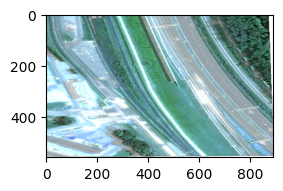

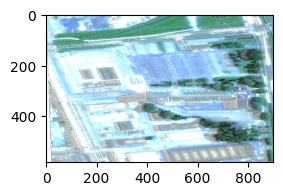

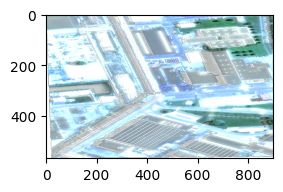

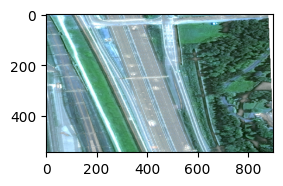

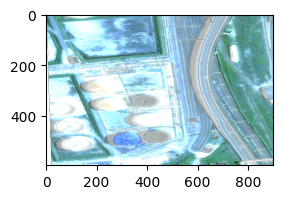

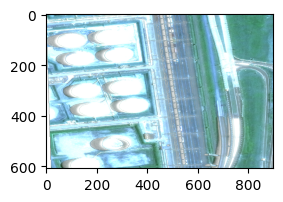

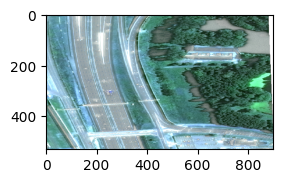

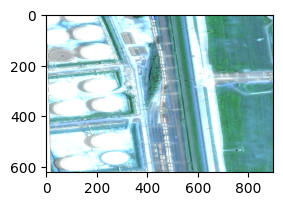

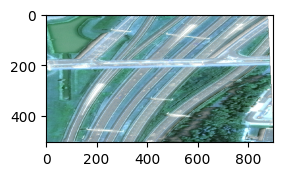

In [16]:
# test rotation on samples
sample_size = 10
gdf = geopandas.read_file(datas[0][1])
testgdf = gdf.copy()
procs = glob.glob('../data/AOI_11_Rotterdam/processed/masked/PS-RGBNIR/*.tif')[:sample_size]
for i, _ in enumerate(procs):
    src = rio.open(procs[i])
    plot_sat(procs[i], gdf_=testgdf, linewidth=2)

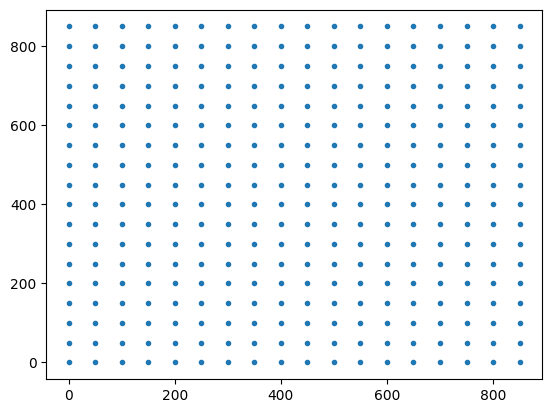

In [17]:
# an example of how to use the circle_coords_fn function to create a meshgrid of pins
testgdf = scale_and_translate(datas[0], plot=False)
circle_coords = create_meshgrid(testgdf, step=50)
circ = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], 1, 100, offset=(0,0))) for circ_coors in circle_coords]

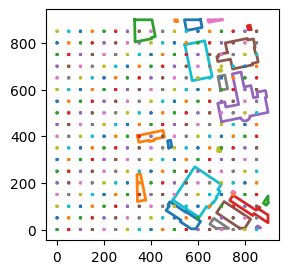

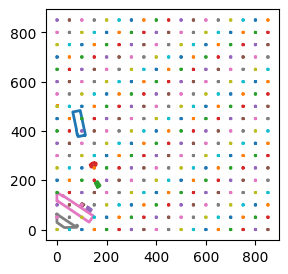

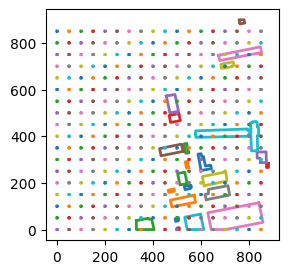

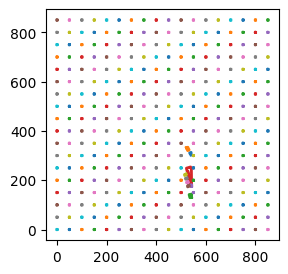

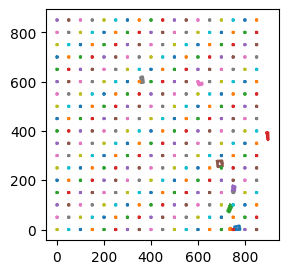

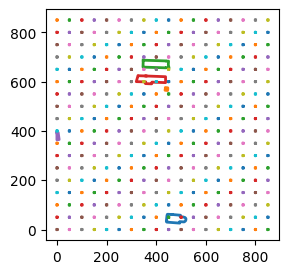

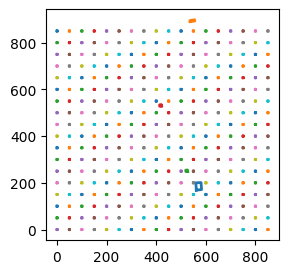

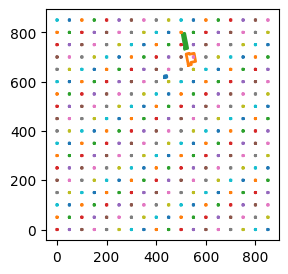

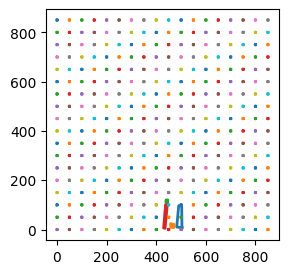

In [18]:
# plot the meshgrid of pins and the test geodataframe
for i, d in enumerate(datas):
    testgdf = scale_and_translate(d, plot=False)
    plot_gdf_circle(testgdf, circ, multicircs=True, kw='geometry')

In [19]:
# count the number of buildings intersected by each pin in the meshgrid
out = generate_pin_counts(datas, rad=10, step=100, stop=len(datas), off=(0, 0), plot=False)

In [20]:
# max buildings intersected by a pin in each output array
[max(out[i][2]) for i in range(len(out))]

[1, 1, 2, 0, 1, 1, 0, 0, 1]

In [21]:
# non-zero array indices for each output array
# confirms that pins are intersecting buildings
[np.nonzero(out[i][2]) for i in range(len(out))]

[(array([ 6,  7,  8, 14, 15, 16, 17, 24, 25, 40, 52, 53, 61, 62, 69, 71, 78,
         80]),),
 (array([ 3,  9, 10]),),
 (array([ 4,  5,  6,  7, 14, 17, 25, 33, 42, 43, 44, 50, 70]),),
 (array([], dtype=int64),),
 (array([60]),),
 (array([24, 40]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([ 5, 11]),)]

In [22]:
# save output to csv to use for model training
pd.DataFrame(out).to_csv('building_test.csv')